# Clase 8 - Taller Práctico: Clustering

**Objetivo:** En este taller, aplicaremos los tres algoritmos de clustering que vimos en la clase teórica para entender sus diferencias, fortalezas y debilidades en la práctica.

1.  **K-Means:** Ideal para clusters de forma esférica y cuando tenemos una idea del número de grupos.
2.  **Clustering Jerárquico:** Útil para explorar la estructura anidada de los datos sin pre-especificar el número de clusters.
3.  **DBSCAN:** Potente para descubrir clusters de formas arbitrarias y para identificar outliers (ruido).

Usaremos datasets sintéticos para tener un control total sobre la estructura de los datos y así evaluar visualmente el rendimiento de cada algoritmo.

In [1]:
# --- 1. Importación de Librerías ---
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Funciones de Scikit-learn
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Funciones de SciPy para el dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

# Configuramos Plotly para que use un tema agradable
px.defaults.template = "plotly_dark"

## Sección 1: K-Means Clustering

Empezamos con K-Means, el algoritmo de clustering más popular. Para mostrar su funcionamiento, creamos un conjunto de datos con `make_blobs` que contiene grupos bien definidos y de forma esférica.

In [2]:
# --- 2. Generación y Visualización de Datos ---
# Creamos un dataset con 300 muestras, 4 centros (clusters) y una desviación estándar de 0.8
X_blobs, y_blobs = make_blobs(n_samples=300,
                              centers=4,
                              cluster_std=0.8,
                              random_state=42,
                              # centers=[[0, 0], [6, 6], [1, 7], [7, 0]],
                              # cluster_std=1.0,
                              )

# Visualizamos los datos sin etiquetas para simular un problema no supervisado
fig = px.scatter(x=X_blobs[:, 0], y=X_blobs[:, 1], title="Dataset Sintético (sin etiquetar)")
fig.update_traces(marker=dict(color='cyan'))
fig.show()

### 1.1 Determinando K: El Método del Codo

Antes de aplicar K-Means, debemos decidir el valor de `K`. El método del codo nos ayuda a encontrar un buen candidato para `K` al graficar la inercia (WCSS) para un rango de valores de `K`.

In [3]:
# --- 3. Implementación del Método del Codo ---
inertia_values = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_blobs)
    inertia_values.append(kmeans.inertia_)

# Graficamos los resultados
fig = px.line(x=k_range, y=inertia_values, title='Método del Codo para Encontrar K Óptimo',
              labels={'x': 'Número de Clusters (K)', 'y': 'Inercia (WCSS)'},
              markers=True)
fig.add_vline(x=4, line_width=3, line_dash="dash", line_color="red", annotation_text="Codo en K=4")
fig.show()

El gráfico muestra un "codo" claro en K=4, que es donde la tasa de disminución de la inercia se aplana. Esto sugiere que 4 es un buen número de clusters para nuestros datos, lo cual coincide con cómo los generamos.

### 1.2 Aplicando K-Means y Evaluando con el Coeficiente de Silueta

In [4]:
# --- 4. Aplicar K-Means con K=4 ---
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans_final.fit(X_blobs)

# Obtenemos las etiquetas de los clusters y los centroides
labels_kmeans = kmeans_final.labels_
centroids = kmeans_final.cluster_centers_

# Calculamos el coeficiente de silueta
silhouette_avg = silhouette_score(X_blobs, labels_kmeans)
print(f"Para K={optimal_k}, el coeficiente de silueta promedio es: {silhouette_avg:.4f}")

Para K=4, el coeficiente de silueta promedio es: 0.8335


Un coeficiente de silueta cercano a 1 indica que los clusters son densos y están bien separados. Nuestro valor es muy bueno.

In [5]:
# --- 5. Visualización de los Resultados de K-Means ---
df_blobs = pd.DataFrame(X_blobs, columns=['X1', 'X2'])
df_blobs['cluster_kmeans'] = labels_kmeans.astype(str) # Convertir a string para colores discretos

fig = px.scatter(df_blobs, x='X1', y='X2', color='cluster_kmeans', 
                 title='Resultados de K-Means Clustering (K=4)')

# Añadimos los centroides al gráfico
fig.add_trace(go.Scatter(x=centroids[:, 0], y=centroids[:, 1],
                          mode='markers', 
                          marker=dict(color='white', size=15, symbol='x'),
                          name='Centroides'))
fig.show()

## Sección 2: Clustering Jerárquico

Usemos el mismo dataset para aplicar clustering jerárquico. La principal ventaja aquí es el **dendrograma**, que nos permite visualizar la estructura anidada de los clusters.

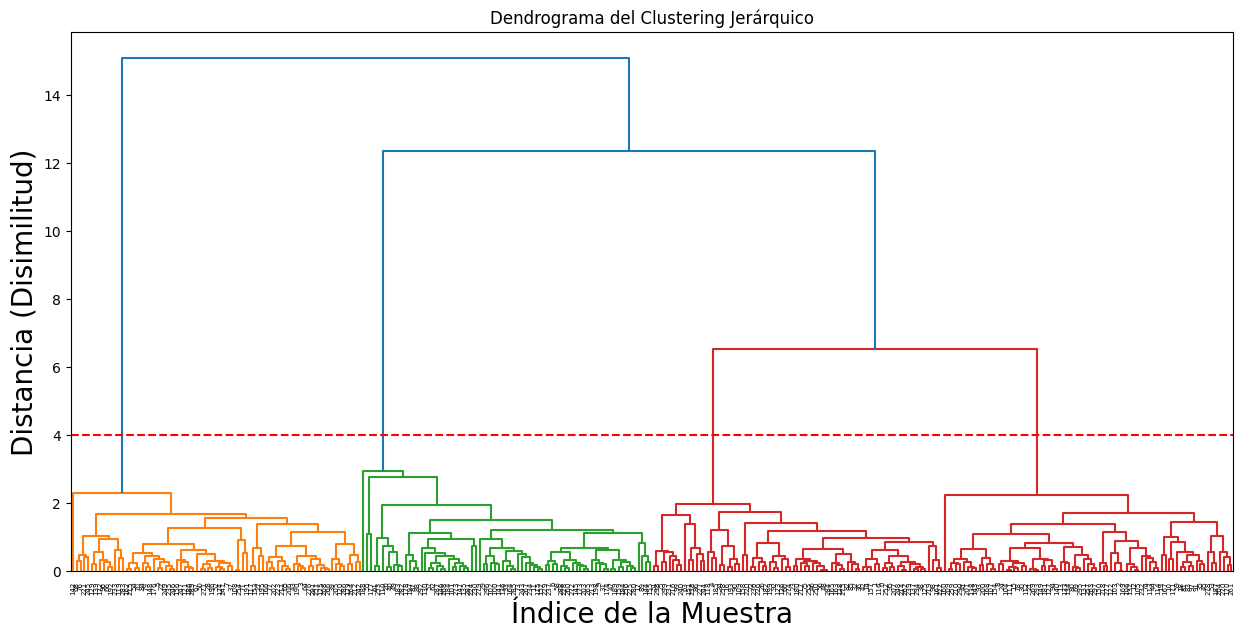

In [6]:
# --- 6. Creación del Dendrograma ---

# Usamos 'average' como método de enlace
linkage_matrix = linkage(X_blobs, method='average')

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Índice de la Muestra', fontsize=20)
plt.ylabel('Distancia (Disimilitud)', fontsize=20)
plt.axhline(y=4, color='r', linestyle='--') # Linea de corte para K=4
plt.show()

El dendrograma muestra que un corte horizontal en la región marcada (línea roja) resultaría en 4 clusters.

### 2.1 Aplicando Clustering Jerárquico Aglomerativo

In [7]:
# --- 7. Aplicar AgglomerativeClustering con 4 clusters ---
agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='average')
labels_agg = agg_cluster.fit_predict(X_blobs)

# Visualizamos los resultados
df_blobs['cluster_agg'] = labels_agg.astype(str)

fig = px.scatter(df_blobs, x='X1', y='X2', color='cluster_agg', 
                 title='Resultados de Clustering Jerárquico (K=4)')
fig.show()

Para este tipo de datos, los resultados de K-Means y Clustering Jerárquico son muy similares, lo cual es de esperar.

## Sección 3: DBSCAN para Formas Complejas

¿Qué pasa cuando los clusters no son esféricos? Aquí es donde K-Means y otros métodos similares fallan. Usaremos el dataset `make_moons` para demostrar la superioridad de DBSCAN en estos escenarios.

In [8]:
# --- 8. Generar y escalar datos no esféricos ---
X_moons, y_moons = make_moons(n_samples=250, noise=0.1, random_state=42)

# DBSCAN es sensible a la escala, por lo que es crucial estandarizar los datos
scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)

# Visualizamos los datos
fig = px.scatter(x=X_moons_scaled[:, 0], y=X_moons_scaled[:, 1], title='Dataset de las Dos Lunas')
fig.update_traces(marker=dict(color='lime'))
fig.show()

### 3.1 El Fracaso de K-Means

In [9]:
# --- 9. Aplicar K-Means a los datos de las lunas ---
kmeans_moons = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_kmeans_moons = kmeans_moons.fit_predict(X_moons_scaled)

df_moons = pd.DataFrame(X_moons_scaled, columns=['X1', 'X2'])
df_moons['cluster_kmeans'] = labels_kmeans_moons.astype(str)

fig = px.scatter(df_moons, x='X1', y='X2', color='cluster_kmeans',
                 title='Resultado de K-Means en el Dataset de Lunas')
fig.show()

Como podemos ver, K-Means falla. Simplemente divide los datos por la mitad, ya que su suposición de clusters esféricos no se cumple.

### 3.2 El Éxito de DBSCAN

In [10]:
# --- 10. Aplicar DBSCAN a los datos de las lunas ---
# La elección de `eps` y `min_samples` es crucial.
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_moons_scaled)

# Los labels -1 corresponden a ruido/outliers
df_moons['cluster_dbscan'] = labels_dbscan.astype(str)

fig = px.scatter(df_moons, x='X1', y='X2', color='cluster_dbscan',
                 title='Resultado de DBSCAN en el Dataset de Lunas',
                 color_discrete_map={'-1': 'red', '0': 'cyan', '1': 'magenta'})
fig.show()

¡Éxito! DBSCAN identifica correctamente las dos lunas como clusters separados. También identifica algunos puntos como ruido (en rojo), lo cual es una de sus grandes ventajas.

## Sección 4: Desafíos y Ejercicios

Hora de experimentar. Utilizá este notebook como base para resolver los siguientes ejercicios.

1.  **K-Means - Variando Datos:** Volvé a generar los datos de `make_blobs`, pero esta vez con `cluster_std=1.5`. ¿Cómo afecta una mayor desviación estándar a los resultados de K-Means? ¿El coeficiente de silueta empeora? ¿Por qué?

2.  **K-Means - Importancia de `n_init`:** Ejecutá K-Means en los datos originales de `make_blobs` con `n_init=1` múltiples veces. ¿Obtienes siempre la misma inercia? Compara estos resultados con `n_init=10` o `n_init=20`.

3.  **K-Means - Silueta para K:** En lugar del método del codo, utilizá el coeficiente de silueta para encontrar el `K` óptimo. Itera a través de un rango de `K` (por ejemplo, de 2 a 10), calcula el `silhouette_score` para cada `K` y grafica los resultados. ¿El `K` que maximiza la silueta coincide con el del método del codo?

4.  **Jerárquico - Linkage:** Cambiá el método de enlace a `'single'` y `'complete'`. ¿Cómo cambian los dendrogramas? ¿Cuál te parece más interpretable para estos datos y por qué?

5.  **Jerárquico - Cortes del Dendrograma:** Utilizando el dendrograma original, modificá la altura del corte (`y` en `plt.axhline`) para obtener 2, 3 y 5 clusters. Describí qué grupos se fusionan o se dividen en cada paso.

6.  **Aplicación General - Dataset Iris:** Importá el famoso dataset Iris de `sklearn.datasets`. Contiene 3 clases de flores. Aplica K-Means (con K=3), Clustering Jerárquico (cortando para obtener 3 clusters) y DBSCAN. ¿Cuál funciona mejor y por qué?

7.  **DBSCAN - Hiperparámetros:** Experimentá con diferentes valores de `eps` (ej. 0.1, 0.5, 1.0) y `min_samples` (ej. 2, 10, 20). ¿Cómo afectan los resultados? ¿Qué pasa si `eps` es muy grande o muy pequeño?

---------------------

#### 1.  **K-Means - Variando Datos:** Volvé a generar los datos de `make_blobs`, pero esta vez con `cluster_std=1.5`. ¿Cómo afecta una mayor desviación estándar a los resultados de K-Means? ¿El coeficiente de silueta empeora? ¿Por qué?

`Respuesta`:

In [ ]:
# ======================================================================================================================================
#
# PREPARACIÓN DEL ENTORNO
#
import numpy as np
import pandas as pd
import plotly.express as px1
from IPython.display import display, Markdown
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ======================================================================================================================================
#
# CARGA Y EXPLORACIÓN DE DATOS
#
from sklearn.datasets import make_blobs

# Carga
X_blobs_1, y_blobs_1 = make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42)

# Visualizamos los datos sin etiquetas
fig = px1.scatter(x=X_blobs_1[:, 0], y=X_blobs_1[:, 1], title="Dataset Sintético (ejercicio 1)")
fig.update_traces(marker=dict(color='orange'))
fig.show()

# ======================================================================================================================================
#
# K-MEANS CLUSTERING: MÉTODO DEL CODO
#
inertia_values_1 = []
k_range_1 = range(1, 11)

for k in k_range_1:
    kmeans_1 = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_1.fit(X_blobs_1)
    inertia_values_1.append(kmeans_1.inertia_)
    
# Graficamos el método del codo
fig = px1.line(x=k_range_1, y=inertia_values_1, title='Método del Codo (ejercicio 1)', 
               labels={'x': 'Número de Clústeres (k)', 'y': 'Inercia'}, markers=True)
fig.add_vline(x=4, line_width=3, line_dash="dash", line_color="red", annotation_text="Codo en K=4")
fig.show()


In [12]:
# ======================================================================================================================================
#
# EVALUANDO EL COEFICIENTE DE SILUETA
#
optimal_k_1 = 4
kmeans_final_1 = KMeans(n_clusters=optimal_k_1, n_init=10, random_state=42)
kmeans_final_1.fit(X_blobs_1)

# Obtener las etiquetas de los clústeres y los centroides
labels_final_1 = kmeans_final_1.labels_
centroids_1 = kmeans_final_1.cluster_centers_

# Calcular el coeficiente de silueta
silhouette_avg_1 = silhouette_score(X_blobs_1, labels_final_1)
display(Markdown(f"**Coeficiente de Silueta (ejercicio 1)**: {silhouette_avg_1:.4f}"))
display(Markdown(f"**Conclusión (ejercicio 1)**. Una desviación mayor (cluster_std=0.8 vs 1.5) genera: \\\n \
                 * clústeres más dispersos; \\\n \
                 * un coeficiente de silueta más bajo (0.8335 vs {silhouette_avg_1:.4f}); \\\n \\\n \
                 El hecho de que el coef de silueta esté mas alejado de 1, indica que los clústeres son menos densos y con límites más difusos."))

**Coeficiente de Silueta (ejercicio 1)**: 0.6912

**Conclusión (ejercicio 1)**. Una desviación mayor (cluster_std=0.8 vs 1.5) genera: \
                  * clústeres más dispersos; \
                  * un coeficiente de silueta más bajo (0.8335 vs 0.6912); \
 \
                  El hecho de que el coef de silueta esté mas alejado de 1, indica que los clústeres son menos densos y con límites más difusos.

---------------------

#### 2.  **K-Means - Importancia de `n_init`:** Ejecutá K-Means en los datos originales de `make_blobs` con `n_init=1` múltiples veces. ¿Obtienes siempre la misma inercia? Compara estos resultados con `n_init=10` o `n_init=20`.

`Respuesta`:

In [32]:
# ======================================================================================================================================
#
# PREPARACIÓN DEL ENTORNO
#
import numpy as np
import pandas as pd
import plotly.express as px1
from IPython.display import display, Markdown
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ======================================================================================================================================
#
# CARGA Y EXPLORACIÓN DE DATOS
#
from sklearn.datasets import make_blobs

# Carga
X_blobs_2, y_blobs_2 = make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42)

# ======================================================================================================================================
#
# K-MEANS CLUSTERING: MÉTODO DEL CODO
#
n_inits_2 = [1, 1, 1, 1, 10, 20]

for i in n_inits_2:
    inertia_values_2 = []
    k_range_2 = range(1, 11)
    for k in k_range_2:
        kmeans_2 = KMeans(n_clusters=k, n_init=i, random_state=42)
        kmeans_2.fit(X_blobs_2)
        inertia_values_2.append(kmeans_2.inertia_)
        
    # Graficamos el método del codo
    fig = px1.line(x=k_range_2, y=inertia_values_2, title='Método del Codo (ejercicio 2) - n_init=' + str(i), 
                labels={'x': 'Número de Clústeres (k)', 'y': 'Inercia'}, markers=True, width=800, height=400)
    fig.add_vline(x=4, line_width=3, line_dash="dash", line_color="red", annotation_text="Codo en K=4")
    fig.show()

`Conclusión`: evidentemente el n_init no afecta la inercia, ya que se obseva el mismo valor para 1, 10 y 20.

---------------------

#### 3.  **K-Means - Silueta para K:** En lugar del método del codo, utilizá el coeficiente de silueta para encontrar el `K` óptimo. Itera a través de un rango de `K` (por ejemplo, de 2 a 10), calcula el `silhouette_score` para cada `K` y grafica los resultados. ¿El `K` que maximiza la silueta coincide con el del método del codo?

In [40]:
# ======================================================================================================================================
#
# PREPARACIÓN DEL ENTORNO
#
import numpy as np
import pandas as pd
import plotly.express as px1
from IPython.display import display, Markdown
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ======================================================================================================================================
#
# CARGA Y EXPLORACIÓN DE DATOS
#
from sklearn.datasets import make_blobs

# Carga
X_blobs_3, y_blobs_3 = make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42)

# ======================================================================================================================================
#
# EVALUANDO EL COEFICIENTE DE SILUETA
#
k_range_3 = range(2, 11)
silhouette_scores_3 = []

for k in k_range_3:
    kmeans_3 = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_3.fit(X_blobs_3)
    silhouette_avg_3 = silhouette_score(X_blobs_3, kmeans_3.labels_)
    silhouette_scores_3.append(silhouette_avg_3)
        
# Graficamos la silueta
fig = px1.line(x=k_range_3, y=silhouette_scores_3, title='Silhouette Score (ejercicio 3)', 
            labels={'x': 'Número de Clústeres (k)', 'y': 'Silhouette Score'}, markers=True, width=800, height=400)
fig.add_vline(x=3, line_width=3, line_dash="dash", line_color="red", annotation_text="K=3")
fig.show()


`Respuesta`: NO, mientras que con el método del codo del k-óptimo es 4, el K que maximiza el coeficiente de silueta, es 3.

---------------------

#### 4.  **Jerárquico - Linkage:** Cambiá el método de enlace a `'single'` y `'complete'`. ¿Cómo cambian los dendrogramas? ¿Cuál te parece más interpretable para estos datos y por qué?

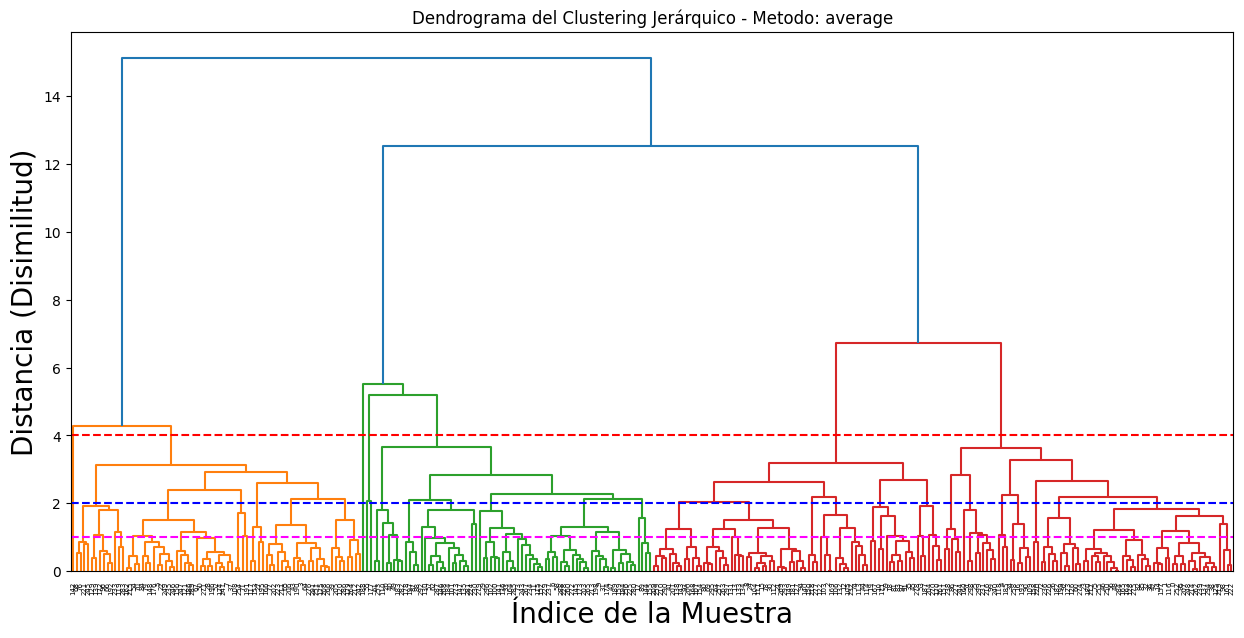

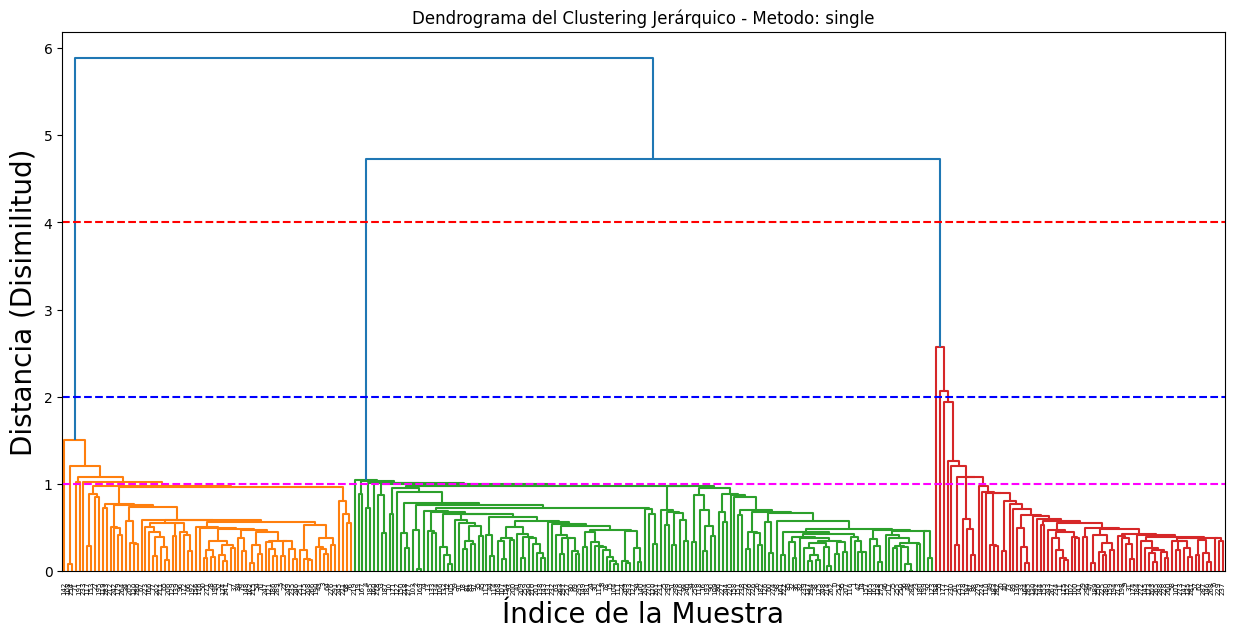

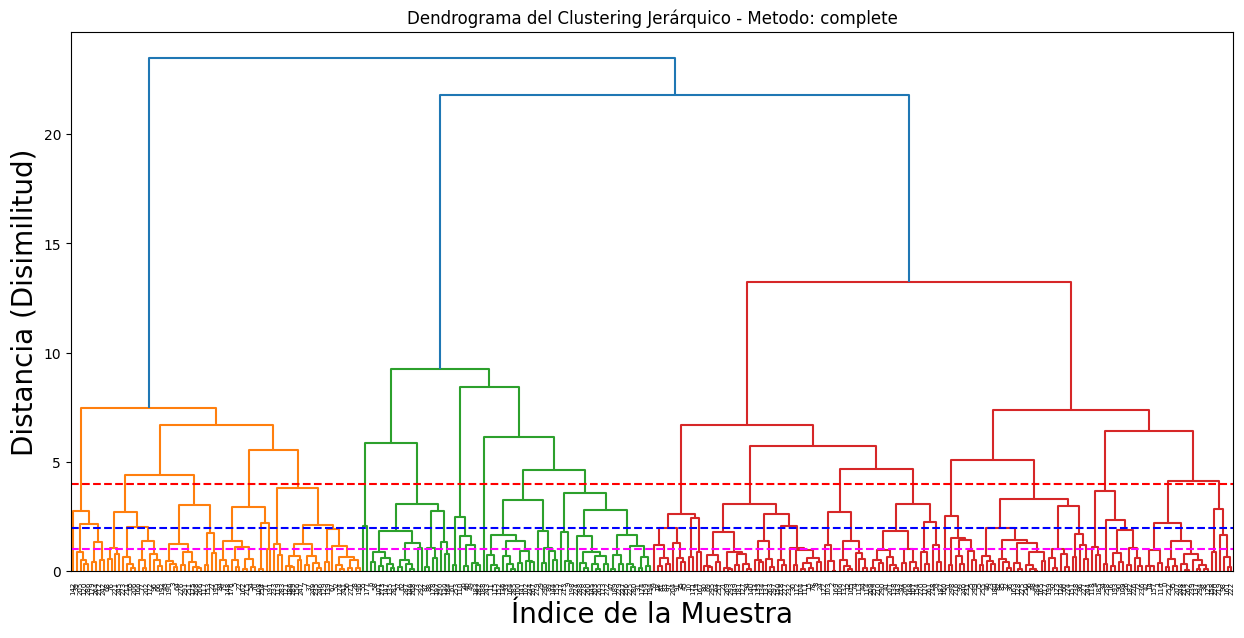

In [50]:
# ======================================================================================================================================
#
# PREPARACIÓN DEL ENTORNO
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Funciones de SciPy para el dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

# ======================================================================================================================================
#
# CARGA Y EXPLORACIÓN DE DATOS
#
from sklearn.datasets import make_blobs

# Carga
X_blobs_4, y_blobs_4 = make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42)

# ======================================================================================================================================
#
# CLUSTERING JERÁRQUICO
#

methods = ['average', 'single', 'complete']

for m in methods:
    linkage_matrix_4 = linkage(X_blobs_4, method=m)

    plt.figure(figsize=(15, 7))
    dendrogram(linkage_matrix_4)
    plt.title(f'Dendrograma del Clustering Jerárquico - Metodo: {m}')
    plt.xlabel('Índice de la Muestra', fontsize=20)
    plt.ylabel('Distancia (Disimilitud)', fontsize=20)
    plt.axhline(y=4, color='r', linestyle='--')
    plt.axhline(y=2, color='b', linestyle='--')
    plt.axhline(y=1, color='fuchsia', linestyle='--')
    plt.show()

`Conclusión`: según se observan los dendrogramas, el método *single* dificulta la identificación del número de clusters. En cambio, el método *complete* facilita esa lectura ya que los clusters son más compactos y se puede identificar mejor número de ellos ante el corte.

---------------------

#### 5.  **Jerárquico - Cortes del Dendrograma:** Utilizando el dendrograma original, modificá la altura del corte (`y` en `plt.axhline`) para obtener 2, 3 y 5 clusters. Describí qué grupos se fusionan o se dividen en cada paso.

`Respuesta`:

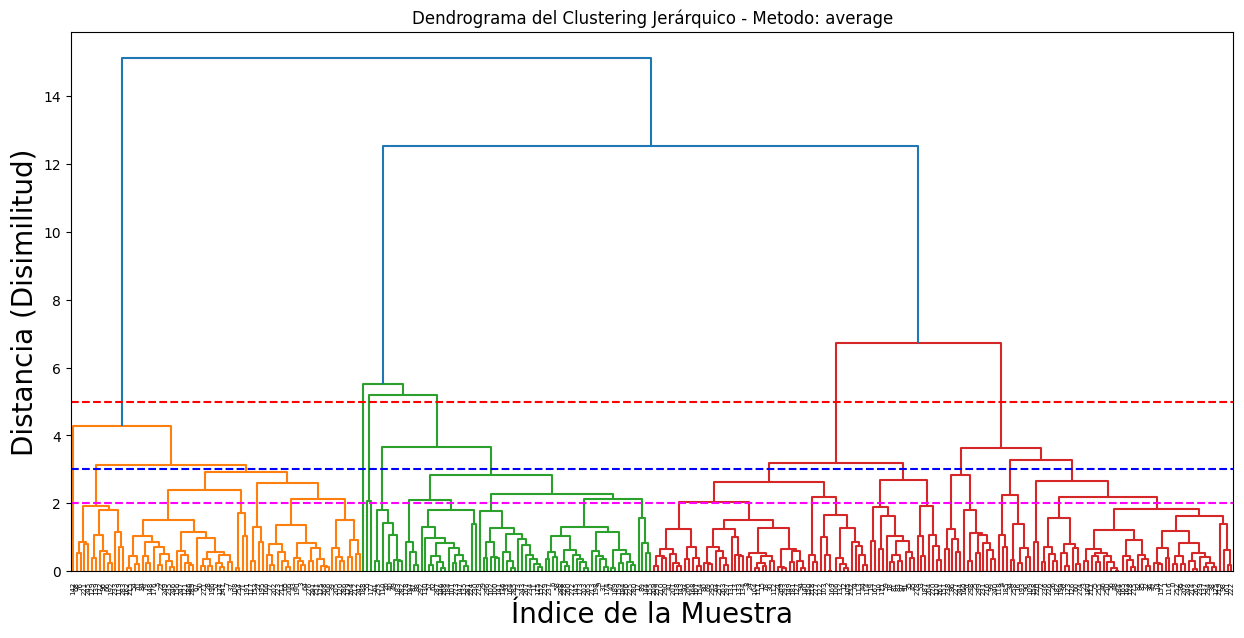

In [66]:
# ======================================================================================================================================
#
# PREPARACIÓN DEL ENTORNO
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Funciones de SciPy para el dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

# ======================================================================================================================================
#
# CARGA Y EXPLORACIÓN DE DATOS
#
from sklearn.datasets import make_blobs

# Carga
X_blobs_5, y_blobs_5 = make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42)

# ======================================================================================================================================
#
# CLUSTERING JERÁRQUICO
#

m = 'average'

linkage_matrix_5 = linkage(X_blobs_5, method=m)

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix_5)
plt.title(f'Dendrograma del Clustering Jerárquico - Metodo: {m}')
plt.xlabel('Índice de la Muestra', fontsize=20)
plt.ylabel('Distancia (Disimilitud)', fontsize=20)
plt.axhline(y=5, color='r', linestyle='--')
plt.axhline(y=3, color='b', linestyle='--')
plt.axhline(y=2, color='fuchsia', linestyle='--')
plt.show()

`Conclusión`: 
- Cortando en y = 5, vemos que el gráfico se divide en 6 clústers.
- Cortando en y = 3, el gráfico se divide en 12 clústers.
- Cortando en y = 2, parecen ser 29 clústers. Pero claramente en es caso se dificulta la lectura e interpretabilidad.

---------------------

#### 6.  **Aplicación General - Dataset Iris:** Importá el famoso dataset Iris de `sklearn.datasets`. Contiene 3 clases de flores. Aplica K-Means (con K=3), Clustering Jerárquico (cortando para obtener 3 clusters) y DBSCAN. ¿Cuál funciona mejor y por qué?

`Respuesta`: 

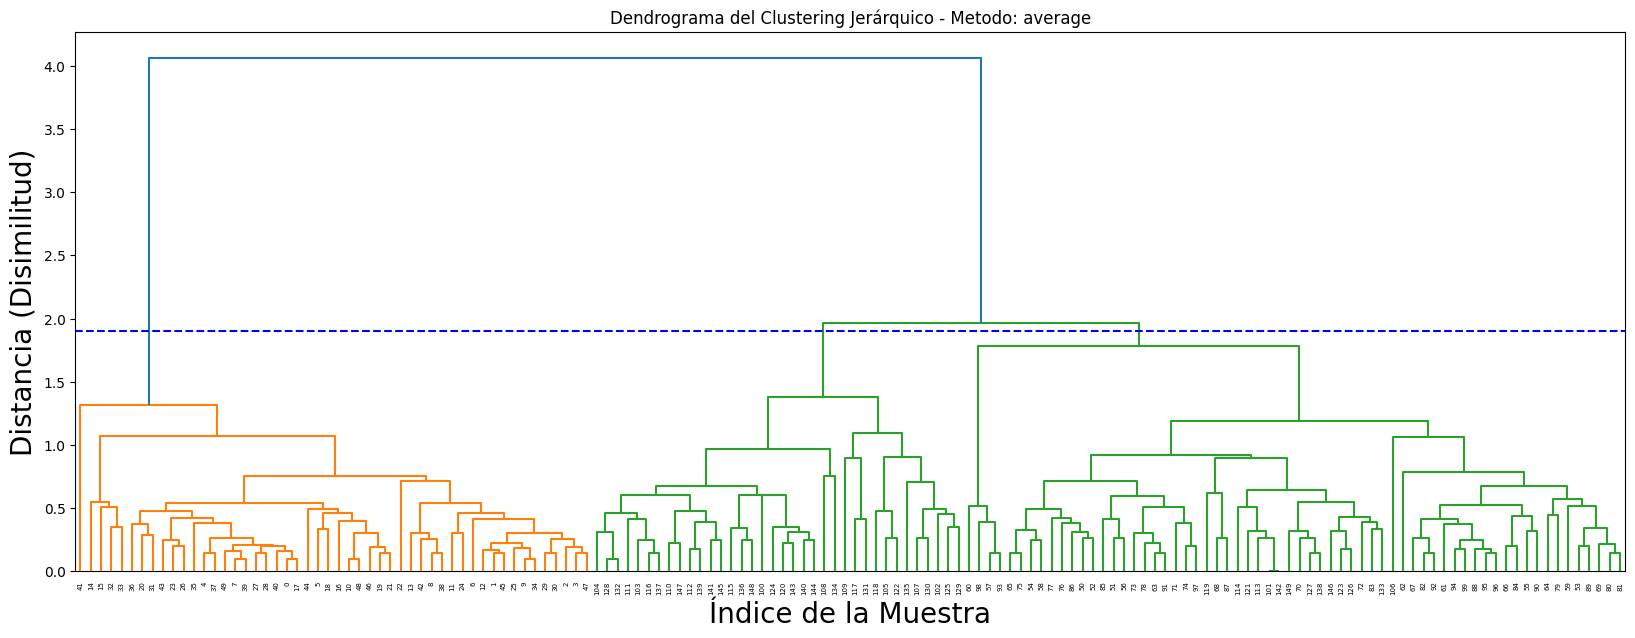

In [71]:
# ======================================================================================================================================
#
# PREPARACIÓN DEL ENTORNO
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px5

# Funciones de SciPy para el dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

# ======================================================================================================================================
#
# CARGA Y EXPLORACIÓN DE DATOS
#

# Carga
from sklearn.datasets import load_iris
data_iris = load_iris(as_frame=True)
df_iris = data_iris.frame

# Características y objetivo
X_iris_5, y_iris_5 = df_iris.iloc[:, :-1].values, df_iris.iloc[:, -1].values

# Visualizamos los datos sin etiquetas
fig = px1.scatter(x=X_iris_5[:, 0], y=X_iris_5[:, 1], title="Dataset Flores (ejercicio 5)")
fig.update_traces(marker=dict(color='orange'))
fig.show()

# ======================================================================================================================================
#
# K-MEANS CLUSTERING: MÉTODO DEL CODO
#
inertia_values_5 = []
k_range_5 = range(1, 11)

for k in k_range_5:
    kmeans_5 = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_5.fit(X_iris_5)
    inertia_values_5.append(kmeans_5.inertia_)

# Graficamos el método del codo
fig = px1.line(x=k_range_5, y=inertia_values_5, title='Método del Codo (ejercicio 5)', 
               labels={'x': 'Número de Clústeres (k)', 'y': 'Inercia'}, markers=True)
fig.add_vline(x=3, line_width=3, line_dash="dash", line_color="red", annotation_text="Codo en K=3")
fig.show()

# # ======================================================================================================================================
# #
# # EVALUANDO EL COEFICIENTE DE SILUETA
# #
# silhouette_scores_5 = []
# k_range_5 = range(2, 11)

# for k in k_range_5:
#     kmeans_5 = KMeans(n_clusters=k, n_init=10, random_state=42)
#     kmeans_5.fit(X_iris_5)
#     silhouette_avg_5 = silhouette_score(X_iris_5, kmeans_5.labels_)
#     silhouette_scores_5.append(silhouette_avg_5)

# # Graficamos la silueta
# fig = px1.line(x=k_range_5, y=silhouette_scores_5, title='Silhouette Score (ejercicio 5)', 
#             labels={'x': 'Número de Clústeres (k)', 'y': 'Silhouette Score'}, markers=True)
# fig.add_vline(x=3, line_width=3, line_dash="dash", line_color="red", annotation_text="K=3")
# fig.show()

# ======================================================================================================================================
#
# CLUSTERING JERÁRQUICO
#

methods = ['average']

for m in methods:
    linkage_matrix_5 = linkage(X_iris_5, method=m)

    plt.figure(figsize=(20, 7))
    dendrogram(linkage_matrix_5)
    plt.title(f'Dendrograma del Clustering Jerárquico - Metodo: {m}')
    plt.xlabel('Índice de la Muestra', fontsize=20)
    plt.ylabel('Distancia (Disimilitud)', fontsize=20)
    plt.axhline(y=1.9, color='b', linestyle='--')
    plt.show()

# ======================================================================================================================================
#
# DBSCAN P/FORMAS COMPLEJAS
#

# DBSCAN es sensible a la escala, por lo que es crucial estandarizar los datos
scaler_5 = StandardScaler()
X_iris_scaled_5 = scaler_5.fit_transform(X_iris_5)

dbscan_5 = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan = dbscan_5.fit_predict(X_iris_scaled_5)

# Los labels -1 corresponden a ruido/outliers
df_iris['cluster_dbscan'] = labels_dbscan.astype(str)

fig = px5.scatter(df_iris, x='sepal length (cm)', y='sepal width (cm)', color='cluster_dbscan',
                 title='Resultado de DBSCAN en el Dataset de Iris',
                 color_discrete_map={'-1': 'red', '0': 'cyan', '1': 'magenta'})
fig.show()



`Conclusión`: según se observa, para el dataset de las flores, K-Means y Clustering Jerárquico (average) permiten ver más claramente los clústers. No así DBSCAN. En este último caso no se pueden ver las separaciones con claridad, posiblmente porque el dataset, originalmente trae las clases bastante mezcladas.

---------------------

#### 7.  **DBSCAN - Hiperparámetros:** Experimentá con diferentes valores de `eps` (ej. 0.1, 0.5, 1.0) y `min_samples` (ej. 2, 10, 20). ¿Cómo afectan los resultados? ¿Qué pasa si `eps` es muy grande o muy pequeño?

`Respuesta`:

In [81]:
# ======================================================================================================================================
#
# PREPARACIÓN DEL ENTORNO
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px7

# Funciones de SciPy para el dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

# ======================================================================================================================================
#
# CARGA Y EXPLORACIÓN DE DATOS
#

# Carga
from sklearn.datasets import load_iris
data_iris_7 = load_iris(as_frame=True)
df_iris_7 = data_iris_7.frame

# Características y objetivo
X_iris_7, y_iris_7 = df_iris_7.iloc[:, :-1].values, df_iris_7.iloc[:, -1].values

# ======================================================================================================================================
#
# DBSCAN
#

# DBSCAN es sensible a la escala, por lo que es crucial estandarizar los datos
scaler_7 = StandardScaler()
X_iris_scaled_7 = scaler_7.fit_transform(X_iris_7)


min_samplesList = [2, 4, 10, 20]
epsList = [0.5, 1, 5, 10]

for min_samples in min_samplesList:
    for eps in epsList:
        dbscan_7 = DBSCAN(eps=eps, min_samples=min_samples)
        labels_dbscan = dbscan_7.fit_predict(X_iris_scaled_7)

        df_iris_7['cluster_dbscan'] = labels_dbscan.astype(str)

        fig = px7.scatter(df_iris_7, x='sepal length (cm)', y='sepal width (cm)', color='cluster_dbscan',
                 title='DBSCAN para eps={}, min_samples={}'.format(eps, min_samples),
                 color_discrete_map={'-1': 'red', '0': 'cyan', '1': 'magenta'})
        fig.show()



`Conclusión`: 
* En la medida que el radio que define la vencidad de un núcleo `(eps)` se achica, se incrementan las cantidades de clústers. Pero según se observa, también crece la cantidad de puntos que no pertencen a ningún clúster (ruido).
* Si nos enfocamos en analizar el parámetro `min_samples`, el cual representa la cantidad mínima de vecinos que debe tener un núcleo para ser considerado como tal, observamos que en la medida que crece, se minimiza la cantidad de clústers (todos los puntos forman parte del mismo clúster). Por el contrario, en la medida que decrece, se genera el mismo efecto que generan los `eps` pequeños: más clústers, más ruido.